# Clasificador  se mensajes SMS utilizando Naive Bayes

In [42]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/petrucci/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/petrucci/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [43]:
sms = pd.read_csv("sms_spam.csv")
sms.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Tamaño del dataset



In [44]:
print('Tamaño del dataset')
print('Número de ejemplos: {}'.format(sms.shape[0]))
print('Número de características: {}'.format(sms.shape[1]))

Tamaño del dataset
Número de ejemplos: 5574
Número de características: 2


Balance de los datos(target) en el dataset

In [45]:
print('Número de mensajes importantes y spam: ')
print(sms['type'].value_counts())

Número de mensajes importantes y spam: 
ham     4827
spam     747
Name: type, dtype: int64


In [46]:
def porcentajeClases(output):
    percent = output.value_counts() 
    clase1 = (percent[0]*100)/(percent[0]+percent[1])
    clase2 = (percent[1]*100)/(percent[0]+percent[1])
    return (clase1, clase2)

In [47]:
[nosp, sp] = porcentajeClases(sms['type'])
print('Porcentaje de mensajes importantes: {}%'.format(nosp))
print('Porcentaje de mensajes spam: {}%'.format(sp))

Porcentaje de mensajes importantes: 86.59849300322928%
Porcentaje de mensajes spam: 13.40150699677072%


Limpieza de los textos

In [48]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
sms['text'] = sms.text.map(lambda x: x.lower())  #Convert all SMS messages to lowercase
sms['text'] = sms.text.str.replace('[^\w\s]','') #Remove punctuation
sms['text'] = [re.sub('[0-9]', '', i) for i in sms['text']] #Remove any numbers 
sms['text'] = sms['text'].apply(nltk.word_tokenize)  #Words tokenize
nltk_words = list(stopwords.words('english')) #List of stopwords in english
for i in range(0,len(sms)):
    sms['text'][i] = [w for w in sms['text'][i] if w not in nltk_words]  
sms['text'] = sms['text'].apply(lambda x: ' '.join(x)) # This converts the list of words into space-separated strings

In [49]:
sms.head()

,type,text
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry wkly comp win fa cup final tkts st ...
3,ham,u dun say early hor u c already say
4,ham,nah dont think goes usf lives around though


Visualización de los datos

In [50]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def generatingWordCloud(text):
    wordcloud = WordCloud(width=800, height=800,background_color='white', min_font_size=10).generate(str(text))  
    plt.figure(figsize=(6, 6), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

Wordcloud de mensajes importantes


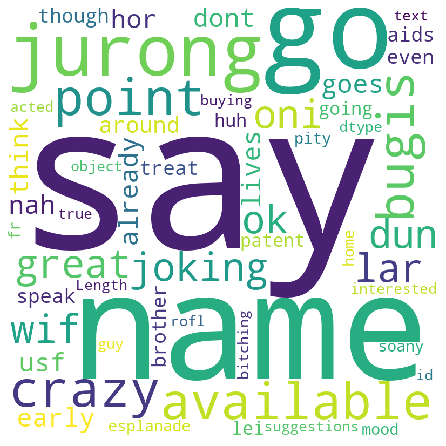

Wordcloud de mensajes spam


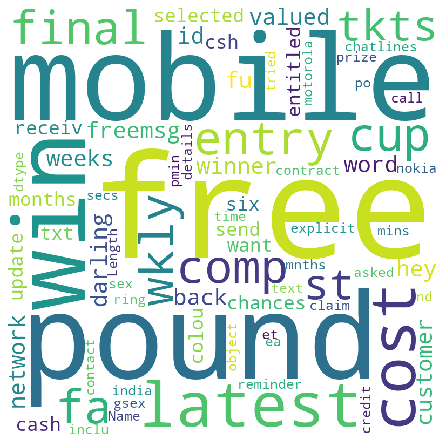

In [51]:
print('Wordcloud de mensajes importantes')
generatingWordCloud(sms.loc[sms['type'] == 'ham'].text)
print('Wordcloud de mensajes spam')
generatingWordCloud(sms.loc[sms['type'] == 'spam'].text)

In [52]:
from sklearn.feature_extraction.text import  CountVectorizer
count_vect = CountVectorizer() #Creamos elmodelo de espacio vectorial (bolsa de palabras)  con los valores tf
bagofWords = count_vect.fit_transform(sms['text'])
print('Tamaño del modelo de espacio vectorial con todas las palabras: ')
print(bagofWords.shape)

Tamaño del modelo de espacio vectorial con todas las palabras: 
(5574, 8482)


In [53]:
count_vect = CountVectorizer(min_df = 8)
bagofWords = count_vect.fit_transform(sms['text'])
print('\nTamaño del modelo de espacio vectorial con las palabras que aparecen en más de 5 mensajes: ')
(bagofWords.shape)


Tamaño del modelo de espacio vectorial con las palabras que aparecen en más de 5 mensajes: 


(5574, 1050)

In [54]:
from scipy.sparse import csr_matrix
from scipy import sparse
bagofWords = bagofWords.toarray()
bagofWords = csr_matrix(bagofWords)

Separación del dataset en un conjunto de entrenamiento y de prueba

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(bagofWords, sms['type'], test_size=0.3, random_state=42)

In [56]:
[nosp, sp] = porcentajeClases(y_train)
print('Porcentaje de mensajes importantes en el conjunto de entrenamiento: {}%'.format(nosp))
print('Porcentaje de mensajes spam en el conjunto de entrenamiento: {}%'.format(sp))

Porcentaje de mensajes importantes en el conjunto de entrenamiento: 86.64445014098949%
Porcentaje de mensajes spam en el conjunto de entrenamiento: 13.35554985901051%


In [57]:
[nosp, sp] = porcentajeClases(y_test)
print('Porcentaje de mensajes importantes en el conjunto de prueba: {}%'.format(nosp))
print('Porcentaje de mensajes spam en el conjunto de prueba: {}%'.format(sp))

Porcentaje de mensajes importantes en el conjunto de prueba: 86.49133293484758%
Porcentaje de mensajes spam en el conjunto de prueba: 13.508667065152421%


Creación del modelo

In [58]:
from sklearn.naive_bayes import MultinomialNB
# The multinomial Naive Bayes classifier is suitable for classification with discrete features (words)
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Evaluación del modelo

Precisión

In [59]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_pred = mnb.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred)
print('Precisión en el conjunto de entrenamiento: {}'.format(train_accuracy))
y_pred = mnb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print('Precisión en el conjunto de prueba: {}'.format(test_accuracy))

Precisión en el conjunto de entrenamiento: 0.981543194052807
Precisión en el conjunto de prueba: 0.9754931261207412


Matriz de confusión

In [60]:
print(pd.crosstab(y_test,y_pred,rownames=['Verdaderos'],colnames=['Predicciones'],margins=True))

Predicciones   ham  spam   All
Verdaderos                    
ham           1424    23  1447
spam            18   208   226
All           1442   231  1673


Reporte de clasificación

In [61]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         ham       0.99      0.98      0.99      1447
        spam       0.90      0.92      0.91       226

    accuracy                           0.98      1673
   macro avg       0.94      0.95      0.95      1673
weighted avg       0.98      0.98      0.98      1673

